In [7]:
import pickle
import matplotlib.pyplot as plt

In [42]:
with open('model_results.pkl', 'rb') as f:
    results_dict = pickle.load(f)

with open('baseline_mnist.pkl', 'rb') as f:
    baseline = pickle.load(f)

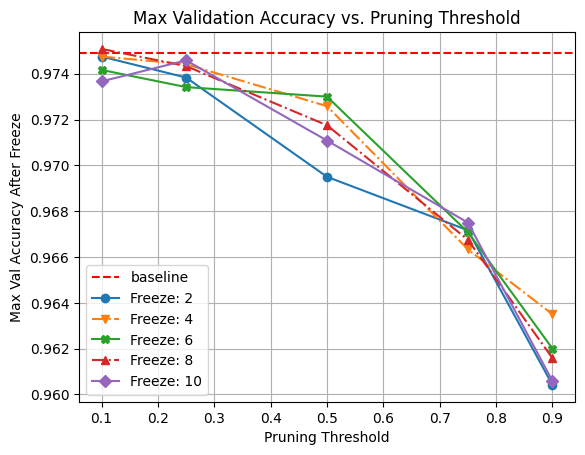

In [47]:
grouped_data = {}
for key, value in results_dict.items():
    freeze = key[1]
    if freeze not in grouped_data:
        grouped_data[freeze] = []
    grouped_data[freeze].append((key[0], max(value[1][freeze:])))

plt.axhline(y=max(baseline[1]), color='r', linestyle='--', label='baseline')

line_styles = ['-', '-.']
markers = ['o', 'v', 'X', '^', 'D']
i = 0
for freeze in sorted(grouped_data.keys()):
    values = grouped_data[freeze]
    values.sort()
    prunes, accuracies = zip(*values)
    plt.plot(prunes, accuracies, label=f'Freeze: {freeze}', marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)])
    i += 1

plt.xlabel('Pruning Threshold')
plt.ylabel('Max Val Accuracy After Freeze')
plt.title('Max Validation Accuracy vs. Pruning Threshold')
plt.legend()
plt.grid(True)
plt.show()

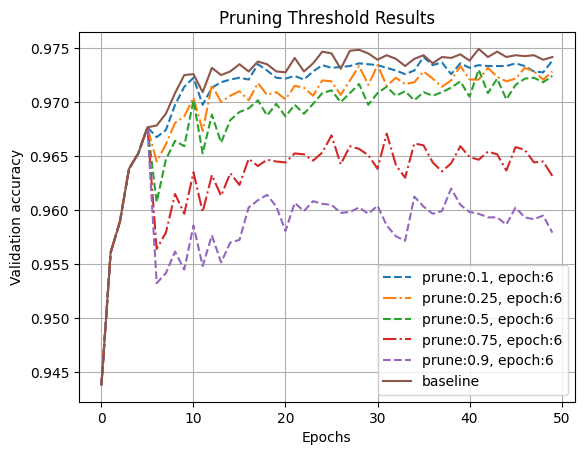

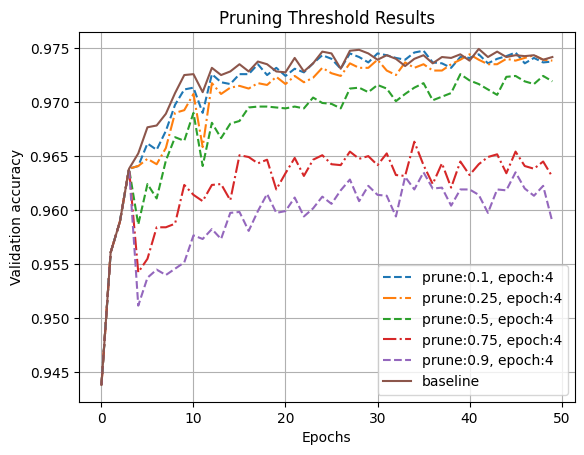

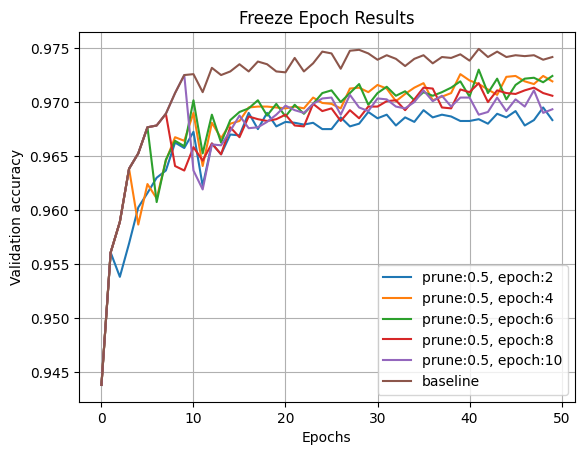

In [14]:
line_styles = ['--', '-.']
pruning =  [.1, .25, .5, .75, .9]
freezing = [ 6,   6,  6,   6,  6]

i = 0
for test in zip(pruning, freezing):
    result = results_dict[test]
    plt.plot(result[1], label=f"prune:{test[0]}, epoch:{test[1]}", linestyle=line_styles[i % len(line_styles)])
    i += 1
plt.plot(baseline[1], label=f"baseline")
plt.title("Pruning Threshold Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.grid(True)
plt.legend()
plt.show()

pruning =  [.1, .25, .5, .75, .9]
freezing = [ 4,   4,  4,   4,  4]

i = 0
for test in zip(pruning, freezing):
    result = results_dict[test]
    plt.plot(result[1], label=f"prune:{test[0]}, epoch:{test[1]}", linestyle=line_styles[i % len(line_styles)])
    i += 1
plt.plot(baseline[1], label=f"baseline")
plt.title("Pruning Threshold Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.grid(True)
plt.legend()
plt.show()

pruning =  [.5, .5, .5, .5, .5]
freezing = [ 2,  4,  6,  8, 10]
i = 0
for test in zip(pruning, freezing):
    result = results_dict[test]
    plt.plot(result[1], label=f"prune:{test[0]}, epoch:{test[1]}")
plt.plot(baseline[1], label=f"baseline")
plt.title("Freeze Epoch Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.grid(True)
plt.legend()
plt.show()

Mem access: 24,807,120,000,000 pJ
Compute: 77,820,412,500.0 pJ
Total: 24.8849404125 J


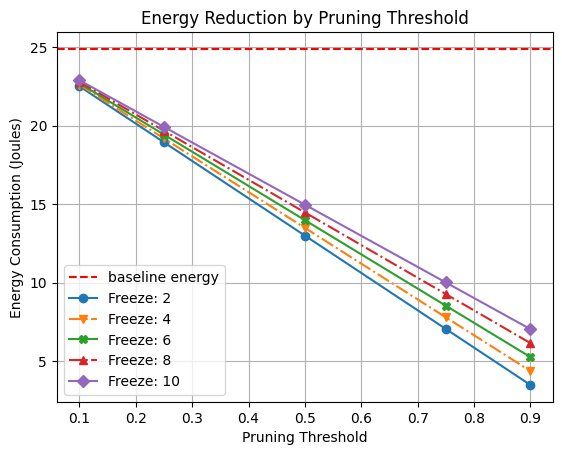

In [64]:
mem_energy = 640
compute_energy = 0.9

num_epochs = 50
num_params = 79510

train_iters = 3000
train_reads = 1 + 1 + 1 # forward, back, update
val_iters = 750
val_reads = 1 # forward

baseline_mem_energy = (train_iters * train_reads + val_iters * val_reads) * num_epochs * mem_energy * num_params
print(f"Mem access: {baseline_mem_energy:,} pJ")

train_compute = 1 + 4 + 2 # forward, back, update
# foward = 2 compute ops == 1 MAC per weight-bias pair: output = weight * input + bias
val_compute = 1 # forward
baseline_compute_energy = (train_iters * train_compute + val_iters * val_compute) * num_epochs * compute_energy * num_params
print(f"Compute: {baseline_compute_energy:,} pJ")

baseline_total_energy = (baseline_compute_energy + baseline_mem_energy) * 1e-12
print(f"Total: {baseline_total_energy:,} J")

prune = 0.9
freeze = 4
def get_pruned_energy(prune, freeze):
    pre_freeze_mem = (train_iters * train_reads + val_iters * val_reads) * freeze * mem_energy * num_params

    post_unfrozen_mem = (train_iters * train_reads + val_iters * val_reads) * (num_epochs - freeze) * mem_energy * (num_params * (1-prune))
    post_unfrozen_compute = (train_iters * train_compute + val_iters * val_compute) * (num_epochs - freeze) * compute_energy * (num_params * (1-prune))

    post_frozen_memcompute = (train_iters * train_reads + val_iters * val_reads) * (num_epochs - freeze) * compute_energy * (num_params * prune)
    post_frozen_compute = (train_iters * train_compute + val_iters * val_compute) * (num_epochs - freeze) * compute_energy * (num_params * prune)


    prune_mem = pre_freeze_mem + post_unfrozen_mem
    prune_compute = post_unfrozen_compute + post_frozen_memcompute + post_frozen_compute
    total_prune_energy = (prune_mem + prune_compute) * 1e-12
    return total_prune_energy


plt.axhline(y=baseline_total_energy, color='r', linestyle='--', label='baseline energy')

line_styles = ['-', '-.']
markers = ['o', 'v', 'X', '^', 'D']
i = 0
for freeze in sorted(grouped_data.keys()):
    energies = []
    values = grouped_data[freeze]
    values.sort()
    prunes, _ = zip(*values)
    energies = [get_pruned_energy(prune, freeze) for prune in prunes]
    plt.plot(prunes, energies, label=f'Freeze: {freeze}', marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)])
    i += 1

plt.xlabel('Pruning Threshold')
plt.ylabel('Energy Consumption (Joules)')
plt.title('Energy Reduction by Pruning Threshold')
plt.legend()
plt.grid(True)
plt.show()

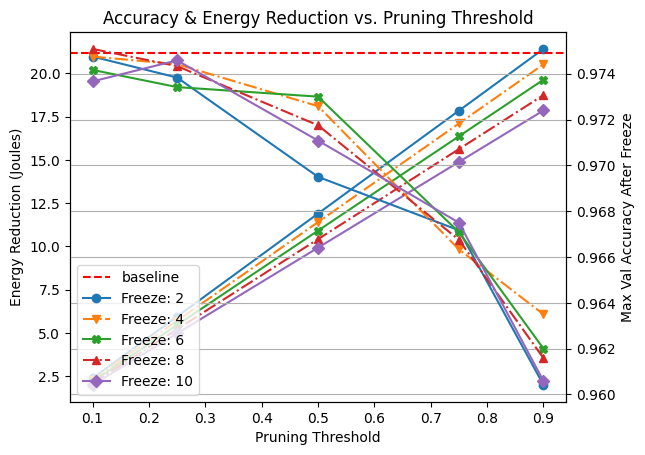

In [61]:
line_styles = ['-', '-.']
markers = ['o', 'v', 'X', '^', 'D']
i = 0
for freeze in sorted(grouped_data.keys()):
    energies = []
    values = grouped_data[freeze]
    values.sort()
    prunes, _ = zip(*values)
    energies = [baseline_total_energy - get_pruned_energy(prune, freeze) for prune in prunes]
    plt.plot(prunes, energies, label=f'Freeze: {freeze}', marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)])
    i += 1

plt.xlabel('Pruning Threshold')
plt.ylabel('Energy Reduction (Joules)')

plt.twinx()

plt.axhline(y=max(baseline[1]), color='r', linestyle='--', label='baseline')

line_styles = ['-', '-.']
markers = ['o', 'v', 'X', '^', 'D']
i = 0
for freeze in sorted(grouped_data.keys()):
    values = grouped_data[freeze]
    values.sort()
    prunes, accuracies = zip(*values)
    plt.plot(prunes, accuracies, label=f'Freeze: {freeze}', marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)])
    i += 1

plt.ylabel('Max Val Accuracy After Freeze')
plt.title('Accuracy & Energy Reduction vs. Pruning Threshold')
plt.legend()
plt.grid(True)
plt.show()